In [44]:
from random import choice
import matplotlib.pyplot as plt
import pandas as pd
from pyvis.network import Network
import seaborn
import spacy

plt.style.use('seaborn')

<hr />

# Text Generator

<hr />
<br />

Hello there, in this notebook I will once again apply graph theory and searching algorithms to play around a grraph structure, but this time I will try something more challenging, like generating a text message based on term relationships within all the ters from the dataset.

Imagine each word relating to each other where each word is node and its relationships are the edges. Sentences are morpholocally structured so basically for a simple study case, al we have to do is give to the agent a *pattern* of a desired sentence, the agent should search thoughg the network for tokens (words) that fits in that structure.

I have dumped like **9356** text messages from my Discord community, collected with a converstional AI chatbot. For exploration, analysis and practice purposes I will make it available and use as study case for this notebook, where the goal is: **To search enough words in a word network graph to build a structured sentence**.

The messages dataset contain messages mostly in brazilian portuguese, which is my native language but it must contain some english words. I will not use of any method of data cleaning to improve results as this is not a data science study case, the data can be improved by cleaning, yes but for example and study exploration purposes only, it will be used as is, the only preprocssing is to extract token part of speech and its dependensy parse.



In [43]:
nlp = spacy.load('pt_core_news_sm')

with open('static/corpora/messages.txt', 'r') as f:
    messages = [nlp(line.strip()) for line in f.readlines()]


9356

In [3]:
def msg_preprocess(text_message: str):
    data = []
    for token in text_message:
        relationships = [c for c in token.children] + [a for a in token.ancestors]
        data.append({
            'token': token,
            'tag': token.pos_,
            'relations': list(set(relationships))
        })
    return data


In [42]:
preprocessed_input = [msg_preprocess(m) for m in messages]
len(preprocessed_input)

9356

In [5]:
class TokenNode:
    def __init__(self, token: str, tag: str, relations: list):
        self.token = token
        self.tag = tag
        self.relations = relations

    def __repr__(self):
        return str(self.token)

    def update_relationship(self, other: list):
        self.relations = list(set(self.relations + other))
        return self.relations

class WordGraph:
    def __init__(self, data):
        self.nodes = self.make_nodes(data)

    def __len__(self):
        return len(self.nodes)

    def make_nodes(self, data):
        nodes = {}
        for message_data in data:
            for node_data in message_data:
                node = TokenNode(**node_data)
                if str(node.token) not in nodes:
                    nodes[str(node.token)] = node
                else:
                    nodes[str(node.token)].update_relationship(node.relations)

        # enforce relationship to the last inserted node
        for k, n in nodes.items():
            if not n.relations:
                nodes[k].relations = [str(node.token)]

        return nodes

In [77]:
class Agent:
    def __init__(self, graph, root):
        self.graph = graph
        self.root = self.graph.nodes[root]
        self.current_position = self.graph.nodes[root]
        self.last_position = None
        self.effort = 0
        self.move_count = 0

    def move(self, node):
        self.last_position = self.current_position
        self.current_position = node
        self.effort += 1
        self.move_count += 1
        return self.current_position


class TextMaker(Agent):
    def __init__(self, graph, root, goal):
        super().__init__(graph, root)
        self.goal = goal
        self.buffer = []

    def __repr__(self):
        return self.view()

    def view(self):
        return ' '.join([str(value.text) for value in self.buffer])

    @property
    def looking_for(self):
        if not self.buffer:
            return self.goal[0]
        return self.goal[len(self.buffer)]

    @property
    def is_pickable(self):
        return self.current_position.tag == self.looking_for

    def pick(self):
        self.buffer.append(self.current_position.token)
        return self.buffer

    def random_search(self):
        self.effort += 1
        return self.graph.nodes[choice(list(self.graph.nodes))]

    def breadth_first_search(self):
        queue = [self.current_position]

        while queue:
            node = queue.pop(0)
            if str(node.tag) == str(self.looking_for):
                return node

            for related in node.relations:
                self.effort += 1
                related = str(related)
                if related in self.graph.nodes:
                    queue.append(self.graph.nodes[related])

        return node

    def depth_first_search(self):
        heap = [self.current_position]
        explored = set()
        while heap:
            node = heap.pop(-1)
            explored.add(str(node.token))
            if str(node.tag) == str(self.looking_for):
                return node

            for related in node.relations:
                self.effort += 1
                related = str(related)
                if related in self.graph.nodes and related not in explored:
                    heap.append(self.graph.nodes[related])
        return node

    def run(self, strategy='random'):
        strategies = {
            'bfs': self.breadth_first_search,
            'random': self.random_search,
            'dfs': self.depth_first_search
        }
        if self.is_pickable:
            self.pick()
        while len(self.buffer) < len(self.goal):
            next_position = strategies[strategy]()
            self.move(next_position)
            if self.is_pickable:
                self.pick()

        return self
        

In [7]:
wg = WordGraph(preprocessed_input)
len(wg)

10274

In [65]:
patterns = [
    ['ADV', 'ADJ', 'AUX', 'NOUN'],
    ['PRON', 'VERB', 'NOUN', 'PRON', 'VERB', 'X'],
    ['VERB', 'SCONJ', 'PRON', 'VERB', 'NOUN'],
    ['VERB', 'DET', 'NOUN', 'VERB', 'PRON'],
    ['PRON', 'VERB', 'NOUN', 'PRON', 'VERB', 'NOUN', 'ADP', 'NOUN']
]
columns = ['Effort', 'Moves', 'Strategy', 'Root', 'Result', 'Pattern']

In [83]:
rows = []
strategy = 'random'
for pattern in patterns:
    for _ in range(5):
        maker = TextMaker(wg, choice(list(wg.nodes)), pattern)
        maker.run(strategy=strategy)
        rows.append([
            maker.effort,
            maker.move_count,
            strategy,
            str(maker.root),
            str(maker),
            maker.goal
        ])

random_dataframe = pd.DataFrame(rows, columns=columns)
random_dataframe

,Effort,Moves,Strategy,Root,Result,Pattern
0,380,190,random,inteira,Entao nerd eut seca,"[ADV, ADJ, AUX, NOUN]"
1,540,270,random,stalk,soy leigo ir cifra,"[ADV, ADJ, AUX, NOUN]"
2,380,190,random,tanga,naive page aind uhsuhshus,"[ADV, ADJ, AUX, NOUN]"
3,228,114,random,revisar,Sim learn vai apicultura,"[ADV, ADJ, AUX, NOUN]"
4,60,30,random,ííí'falta,propositalmente primeira Kd brainfuck,"[ADV, ADJ, AUX, NOUN]"
5,828,414,random,obvio,Ao fura dinheiro cage maringá mor,"[PRON, VERB, NOUN, PRON, VERB, X]"
6,1264,632,random,nutrientes,consigo separa culpa sse amorando figure,"[PRON, VERB, NOUN, PRON, VERB, X]"
7,670,335,random,linuxXWin,deles alive seie quw lê-se zoada,"[PRON, VERB, NOUN, PRON, VERB, X]"
8,884,442,random,ano,si contrair leitura noble portao fine,"[PRON, VERB, NOUN, PRON, VERB, X]"
9,296,148,random,tia,Ao tentaram cheiro Adão session fett,"[PRON, VERB, NOUN, PRON, VERB, X]"


<AxesSubplot:>

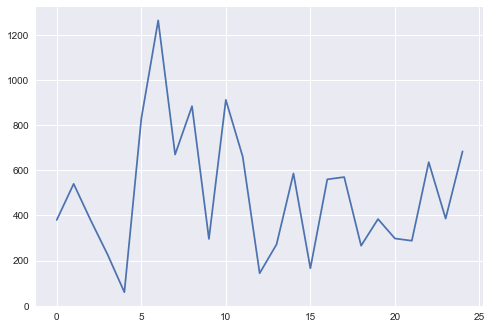

In [89]:
random_dataframe.Effort.plot()

In [85]:
rows = []
strategy = 'bfs'
for pattern in patterns:
    for _ in range(5):
        maker = TextMaker(wg, choice(list(wg.nodes)), pattern)
        maker.run(strategy=strategy)
        rows.append([
            maker.effort,
            maker.move_count,
            strategy,
            str(maker.root),
            str(maker),
            maker.goal
        ])

bfs_dataframe = pd.DataFrame(rows, columns=columns)
bfs_dataframe

,Effort,Moves,Strategy,Root,Result,Pattern
0,25315,4,bfs,can,sure means tem inicio,"[ADV, ADJ, AUX, NOUN]"
1,24575,4,bfs,loop,Não fina tem inicio,"[ADV, ADJ, AUX, NOUN]"
2,54985,4,bfs,mapa,sim específico tem inicio,"[ADV, ADJ, AUX, NOUN]"
3,65527,4,bfs,fantástico,sim específico tem inicio,"[ADV, ADJ, AUX, NOUN]"
4,34199,4,bfs,debugar,Entao tatara tem inicio,"[ADV, ADJ, AUX, NOUN]"
5,218042,6,bfs,ininteligível,Ai porra cara o tenho mes,"[PRON, VERB, NOUN, PRON, VERB, X]"
6,371756,6,bfs,256,ela sei maquina dele cedeu back,"[PRON, VERB, NOUN, PRON, VERB, X]"
7,69266,6,bfs,pinta,nada espero norte ele dizia back,"[PRON, VERB, NOUN, PRON, VERB, X]"
8,377006,6,bfs,responsabilidade,se sei maquina dele cedeu back,"[PRON, VERB, NOUN, PRON, VERB, X]"
9,211803,6,bfs,implementando,ele dizia pai o tenho mes,"[PRON, VERB, NOUN, PRON, VERB, X]"


<AxesSubplot:>

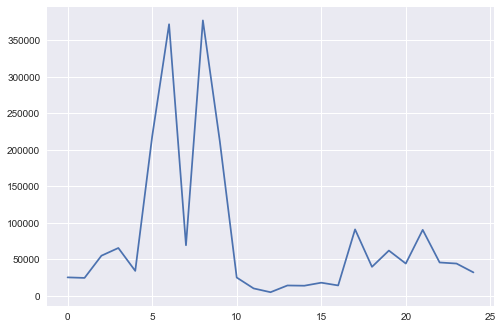

In [97]:
bfs_dataframe.Effort.plot()

In [86]:
rows = []
strategy = 'dfs'
for pattern in patterns:
    for _ in range(5):
        maker = TextMaker(wg, choice(list(wg.nodes)), pattern)
        maker.run(strategy=strategy)
        rows.append([
            maker.effort,
            maker.move_count,
            strategy,
            str(maker.root),
            str(maker),
            maker.goal
        ])

dfs_dataframe = pd.DataFrame(rows, columns=columns)
dfs_dataframe

,Effort,Moves,Strategy,Root,Result,Pattern
0,10168,4,dfs,verificar,irreverente facil ser hmm,"[ADV, ADJ, AUX, NOUN]"
1,35540,4,dfs,lâmpada,bastante certo ser hmm,"[ADV, ADJ, AUX, NOUN]"
2,35540,4,dfs,3.7.9,bastante certo ser hmm,"[ADV, ADJ, AUX, NOUN]"
3,18725,4,dfs,4,junto champanhe é requisição,"[ADV, ADJ, AUX, NOUN]"
4,13095,3,dfs,Assim,Assim Bom é requisição,"[ADV, ADJ, AUX, NOUN]"
5,63382,6,dfs,visual,ele gosta requisição ela ofender bb,"[PRON, VERB, NOUN, PRON, VERB, X]"
6,62828,6,dfs,pse,me alem requisição ela ofender bb,"[PRON, VERB, NOUN, PRON, VERB, X]"
7,56713,6,dfs,ixa,eu ganhar dinheiro me alem bb,"[PRON, VERB, NOUN, PRON, VERB, X]"
8,79197,6,dfs,jadoo,ela ofender dia se ofender bb,"[PRON, VERB, NOUN, PRON, VERB, X]"
9,52796,6,dfs,oera,isso mutar vezes eu ganhar bb,"[PRON, VERB, NOUN, PRON, VERB, X]"


<AxesSubplot:>

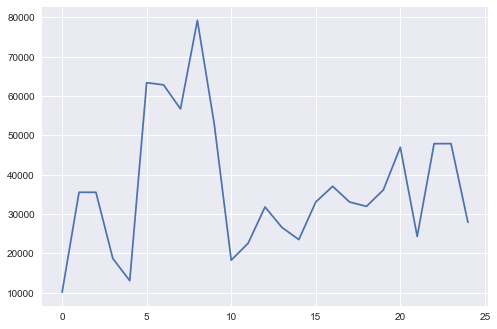

In [98]:
dfs_dataframe.Effort.plot()

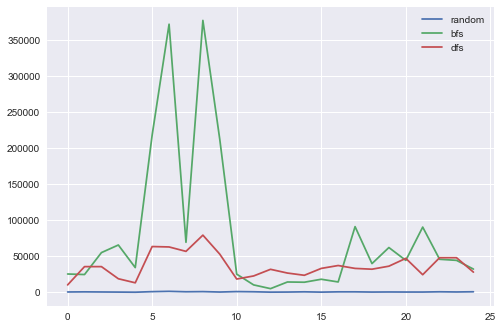

In [87]:
for label, d in (('random', random_dataframe), ('bfs', bfs_dataframe), ('dfs', dfs_dataframe)):
    plt.plot(d.Effort, label=label)
plt.legend()
plt.show()

If you became curious to see what the graph would looks like, it is possible to plot its network. The total network is made of more than 10 thousand nodes, so for demonstration view purposes I will plot only 100 nodes:

In [101]:
test_net = WordGraph(preprocessed_input[:100])

# Graph visualization
net = Network(
    height='850px',
    width='100%',
    bgcolor='#222222',
    font_color='white',
    notebook=True
)
# Add nodes to the network graph
for node in test_net.nodes:
    net.add_node(node, node, title=node)
    
# link nodes with edges
for node in test_net.nodes.values():
    for edge in node.relations:
        net.add_edge(str(node.token), str(edge), value=str(node.tag))

# View graph
net.show('net.html')

Out[1]:

![100nodes](https://github.com/brunolcarli/GooGraph/blob/master/static/img/message100nodes.png?raw=true)

Out[2]:

![100nodes2](https://github.com/brunolcarli/GooGraph/blob/master/static/img/message100nodes2.png?raw=true)

A graph with 2000 nodes view would be like:

![2000nodes1](https://github.com/brunolcarli/GooGraph/blob/master/static/img/message2000nodes.png?raw=true)

![2000nodes2](https://github.com/brunolcarli/GooGraph/blob/master/static/img/message2000nodes2.png?raw=true)